In [2]:
from ephys import core, events
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import combinations
%matplotlib inline

In [3]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

block_path = '/home/brad/krista/B1083/P03S05/'

# load spikes, stimuli, clusters
spikes = core.load_spikes(block_path)
clusters = core.load_clusters(block_path)
trials = events.load_trials(block_path)

In [4]:
def get_average_firing_rate(spikes, cluster_id, t_start, t_end, fs):
    '''
    Compute the average firing rate of the cluster <cluster_id> during the time interval [t_start, t_end]
    Average firing rate is (# of spikes in interval) / (duration of interval)
    '''
    cluster_spikes_in_interval = spikes[(spikes['cluster'] == cluster_id) &
                            (spikes['time_samples'] < t_end) & 
                            (spikes['time_samples'] > t_start)
    ]
    n_spikes = cluster_spikes_in_interval.size
    dt = (t_end - t_start) / fs
    return n_spikes / dt

def get_stimulus_average_firing_rate(spikes, trials, cluster_id, stimulus_id, fs):
    '''
    Return the average firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    avg_fr = 0
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        avg_fr += get_average_firing_rate(spikes , cluster_id, s_start, s_end, fs)
    return avg_fr / stim_trials.size

def get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=[0,1]):
    '''
    Return the mean and standard deviation firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    fr_list=[]
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        fr_list.append(get_average_firing_rate(spikes , cluster_id, int_start, int_end, fs))
        
    return (np.mean(fr_list), np.std(fr_list))

    
def get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs):
    '''
    Get the average responses from all stimuli for a pair of cells
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    ret = []
    for stim in stimuli:
        cluster_a_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_a, stim, fs)
        cluster_b_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_b, stim, fs)
        ret.append([cluster_a_avg_response, cluster_b_avg_response])
    return np.array(ret)


### Noise correlation funcs
def get_zscore_responses(spikes, trials, cluster_id, stimulus_id, fs, interval=[0, 1]):
    ''' Return an array of the z-scored responses from each trial for a given stim and cell'''
    
    # get mean and standard deviation response
    degenerate = False
    mu, sig = get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=interval)
    if (sig < 1e-12):
        print("Uh Oh... standard deviation very small")
        print("Cluster: {} Stimulus: {} mu: {} sigma: {}".format(cluster_id, stimulus_id, mu, sig))
        degenerate = True
    
    # for each trial compute z-score
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    stim_clu_zscores = []
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        if degenerate:
            stim_clu_zscores.append(0.0)
        else:
            trial_fr = get_average_firing_rate(spikes, cluster_id, int_start, int_end, fs)
            zscore = (trial_fr - mu)/sig
            stim_clu_zscores.append(zscore)
    return np.array(stim_clu_zscores)
    
def get_stim_zscores(spikes, trials, clusters, stimulus_id, fs, interval=[0, 1]):
    ''' Get an ncell x ntrial array of zscores for a given stim'''
    
    stimulus_zscores = []
    for cluster in clusters:
        stimulus_zscores.append(get_zscore_responses(spikes, trials, cluster, stimulus_id, fs, interval=interval))
    return np.vstack(stimulus_zscores)

def get_all_stim_zscores(spikes, trials, clusters, fs, interval=[0, 1]):
    ''' Return an ncell x ntrial x nstim array of zscores'''
    
    stimuli = sorted(trials['stimulus'].unique())
    all_stim_zscores = []
    for stim in stimuli:
        all_stim_zscores.append(get_stim_zscores(spikes, trials, clusters, stim, fs, interval=interval))
    return np.dstack(all_stim_zscores)
    
def get_pair_noise_correlation(stim_zscores, cluster_a, cluster_b):
    '''
    given an ncell x ntrial array of z-scores, compute the noise correlation between cells index a and index b
    cluster_a is the *index* of the cell, not its id
    '''

    z_a = stim_zscores[cluster_a, :]
    z_b = stim_zscores[cluster_b, :]
    return pearsonr(z_a, z_b)[0]

def get_pair_stim_avg_noise_correlation(all_stim_zscores, cluster_a, cluster_b):
    '''
    For a pair of cells given by *index* cluster_a, cluster_b, compute the noise correlation averaged over all stimuli
    
    '''
    
    nstim = all_stim_zscores.shape[2]
    corrs = []
    for stimnum in range(nstim):
        corrs.append(get_pair_noise_correlation(all_stim_zscores[:, :, stimnum], cluster_a, cluster_b))
    return np.mean(corrs)

def get_all_stim_avg_noise_correlation(all_stim_zscores, clusters):
    ''' Compute the stimulus averaged noise correlation from all pairs of cells
    all_stim_zscores is an ncell x ntrial x nstim array
    
    '''
    
    all_noise_corrs = []
    for pair in tqdm(combinations(range(len(clusters)),2)):
        all_noise_corrs.append(get_pair_stim_avg_noise_correlation(all_stim_zscores, pair[0], pair[1]))
    return np.array(all_noise_corrs)
    
###################################   
## Signal correlations
def get_signal_correlation(spikes, trials, cluster_a, cluster_b, fs):
    ''' Compute the signal correlation for a pair of cells
    
    spikes - spikes dataframe
    trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
    cluster_a - the *cluster id* of the first cell in the pair
    cluster_b - the *cluster id* of the second cell in the pair
    fs - sampling rate
    '''
    
    stim_responses = get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs)
    stim_correlation = pearsonr(stim_responses[:, 0], stim_responses[:, 1])[0]
    return stim_correlation

def get_all_average_responses(spikes, trials, clusters, fs):
    ''' Return an ncell x nstim matrix of trial-averaged firing rate responses 
        spikes - spikes dataframe
        trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
        clusters - list of *cluster ids* for which you wish to compute average responses
                    the output array will have clusters indexed in this order
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    responses = np.zeros((len(clusters), len(stimuli)))
    for i in tqdm(range(len(clusters))):
        for j in range(len(stimuli)):
            responses[i, j] = get_stimulus_average_firing_rate(spikes, trials, clusters[i], stimuli[j], fs)
    return responses

from tqdm import tqdm
def get_all_signal_correlations(responses, clusters):
    ''' given an ncell x nstim matrix of trial averaged firing rate responses, 
    compute the signal correlations for every pair.
    
    responses - an ncell x nstim matrix of trial averaged firing rate responses
    clusters - array of *cluster ids* corresponding to the order of the rows in the response matrix
    '''
    all_pairs_signal_correlations = []
    for pair in tqdm(combinations(range(len(clusters)), 2)):
        response_a = responses[pair[0], :]
        response_b = responses[pair[1], :]
        pair_sig_corr = pearsonr(response_a, response_b)[0]
        all_pairs_signal_correlations.append(pair_sig_corr)
    return np.array(all_pairs_signal_correlations)

In [5]:
good_clusters = clusters[clusters['quality'] == 'Good']['cluster'].unique()
fs = 30000

responses = get_all_average_responses(spikes, trials, good_clusters, fs)
signal_corrs = get_all_signal_correlations(responses, good_clusters)

zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs)
noise_corrs = get_all_stim_avg_noise_correlation(zscores, good_clusters)

100%|██████████| 95/95 [00:17<00:00,  5.49it/s]
4465it [00:00, 19450.77it/s]


Uh Oh... standard deviation very small
Cluster: 86 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: L_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 53 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 84 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: P_40k mu: 0.0 sigma: 0.0


0it [00:00, ?it/s]/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
4465it [00:02, 2168.08it/s]


(array([  7.,   4.,  16.,  24.,  40.,  55.,  70.,  90., 118., 135., 143.,
        186., 159., 224., 211., 230., 203., 243., 219., 202., 203., 203.,
        164., 170., 159., 133., 120., 138., 103., 109.,  99.,  85.,  87.,
         72.,  41.]),
 array([-0.92545964, -0.87061709, -0.81577455, -0.76093201, -0.70608946,
        -0.65124692, -0.59640437, -0.54156183, -0.48671929, -0.43187674,
        -0.3770342 , -0.32219165, -0.26734911, -0.21250656, -0.15766402,
        -0.10282148, -0.04797893,  0.00686361,  0.06170616,  0.1165487 ,
         0.17139124,  0.22623379,  0.28107633,  0.33591888,  0.39076142,
         0.44560396,  0.50044651,  0.55528905,  0.6101316 ,  0.66497414,
         0.71981668,  0.77465923,  0.82950177,  0.88434432,  0.93918686,
         0.99402941]),
 <a list of 35 Patch objects>)

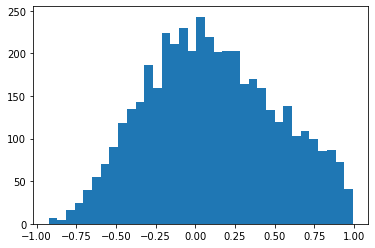

In [6]:
plt.hist(signal_corrs, bins=35)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  4.,   5.,   7.,  13.,  12.,  21.,  44.,  79., 107., 199., 250.,
        334., 401., 467., 500., 419., 367., 283., 220., 150.,  82.,  49.,
         35.,  14.,  13.,   9.,   5.,   2.,   0.,   0.,   1.,   1.,   1.,
          0.,   1.]),
 array([-0.40747894, -0.37759697, -0.34771501, -0.31783305, -0.28795108,
        -0.25806912, -0.22818715, -0.19830519, -0.16842322, -0.13854126,
        -0.10865929, -0.07877733, -0.04889536, -0.0190134 ,  0.01086857,
         0.04075053,  0.0706325 ,  0.10051446,  0.13039643,  0.16027839,
         0.19016036,  0.22004232,  0.24992429,  0.27980625,  0.30968822,
         0.33957018,  0.36945215,  0.39933411,  0.42921608,  0.45909804,
         0.48898001,  0.51886197,  0.54874394,  0.5786259 ,  0.60850787,
         0.63838983]),
 <a list of 35 Patch objects>)

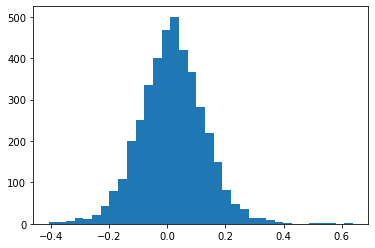

In [7]:
plt.hist(noise_corrs, bins=35)

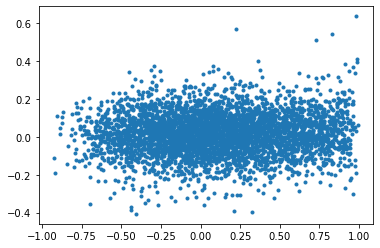

In [8]:
plt.plot(signal_corrs, noise_corrs, '.')

In [9]:
nas = np.logical_or(np.isnan(signal_corrs), np.isnan(noise_corrs))
print(pearsonr(signal_corrs[~nas], noise_corrs[~nas]))

(0.0551156216357711, 0.00041780423609992924)


In [ ]:
np.isnan(noise_corrs[nas]).any()

In [14]:
np.nanmean(noise_corrs)

0.13047003382751018

In [10]:
stimuli = sorted(trials['stimulus'].unique())
print(stimuli)

['I_40k', 'J_40k', 'K_40k', 'L_40k', 'M_40k', 'N_40k', 'O_40k', 'P_40k']


In [11]:
fam_stim = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
unfam_stim = ['I_40k', 'J_40k', 'K_40k', 'L_40k']

fam_trials = trials[trials['stimulus'].isin(fam_stim)]
unfam_trials = trials[trials['stimulus'].isin(unfam_stim)]

In [12]:
fam_responses = get_all_average_responses(spikes, fam_trials, good_clusters, fs)
unfam_responses = get_all_average_responses(spikes, unfam_trials, good_clusters, fs)
fam_signal_corrs = get_all_signal_correlations(fam_responses, good_clusters)
unfam_signal_corrs = get_all_signal_correlations(unfam_responses, good_clusters)

fam_zscores = get_all_stim_zscores(spikes, fam_trials, good_clusters, fs)
fam_noise_corrs = get_all_stim_avg_noise_correlation(fam_zscores, good_clusters)
unfam_zscores = get_all_stim_zscores(spikes, unfam_trials, good_clusters, fs)
unfam_noise_corrs = get_all_stim_avg_noise_correlation(unfam_zscores, good_clusters)

100%|██████████| 95/95 [00:08<00:00, 11.03it/s]
4465it [00:00, 19668.96it/s]
4465it [00:00, 19604.48it/s]


Uh Oh... standard deviation very small
Cluster: 86 Stimulus: N_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: O_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 53 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 67 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 84 Stimulus: P_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: P_40k mu: 0.0 sigma: 0.0


0it [00:00, ?it/s]/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
4465it [00:01, 4076.28it/s]


Uh Oh... standard deviation very small
Cluster: 86 Stimulus: I_40k mu: 0.0 sigma: 0.0
Uh Oh... standard deviation very small
Cluster: 86 Stimulus: L_40k mu: 0.0 sigma: 0.0


4465it [00:01, 4176.23it/s]


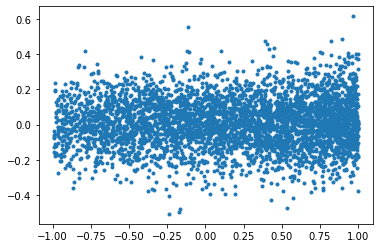

In [13]:
plt.plot(fam_signal_corrs, fam_noise_corrs, '.')

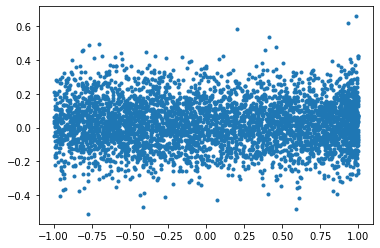

In [14]:
plt.plot(unfam_signal_corrs, unfam_noise_corrs, '.')

In [15]:
nas = np.logical_or(np.isnan(fam_signal_corrs), np.isnan(fam_noise_corrs))
print(pearsonr(fam_signal_corrs[~nas], fam_noise_corrs[~nas]))

(0.022401742370244514, 0.15177821030231303)


In [16]:
nas = np.logical_or(np.isnan(unfam_signal_corrs), np.isnan(unfam_noise_corrs))
print(pearsonr(unfam_signal_corrs[~nas], unfam_noise_corrs[~nas]))

(0.0008331938974448556, 0.9560829741261581)


(array([ 57.,  62.,  61.,  78.,  75.,  95.,  95.,  90., 112.,  92., 108.,
        109., 112., 112., 123., 127., 107., 124., 129., 135., 119., 114.,
        129., 150., 152., 119., 161., 144., 152., 154., 204., 196., 201.,
        221., 246.]),
 array([-0.99454845, -0.93757537, -0.88060228, -0.8236292 , -0.76665612,
        -0.70968304, -0.65270996, -0.59573687, -0.53876379, -0.48179071,
        -0.42481763, -0.36784455, -0.31087146, -0.25389838, -0.1969253 ,
        -0.13995222, -0.08297914, -0.02600605,  0.03096703,  0.08794011,
         0.14491319,  0.20188627,  0.25885935,  0.31583244,  0.37280552,
         0.4297786 ,  0.48675168,  0.54372476,  0.60069785,  0.65767093,
         0.71464401,  0.77161709,  0.82859017,  0.88556326,  0.94253634,
         0.99950942]),
 <a list of 35 Patch objects>)

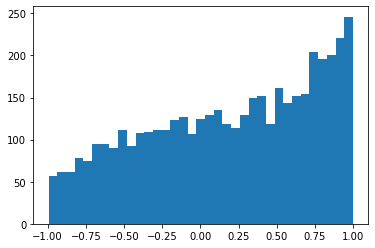

In [17]:
plt.hist(fam_signal_corrs, bins=35)

(array([108.,  90., 109., 125., 149., 126., 146., 135., 133., 135., 134.,
        134., 130., 117., 106., 120., 119., 107.,  92., 113., 115.,  87.,
        101., 111.,  87., 122., 125., 113., 111., 124., 113., 136., 150.,
        211., 331.]),
 array([-0.99971383, -0.94259588, -0.88547793, -0.82835998, -0.77124203,
        -0.71412408, -0.65700613, -0.59988819, -0.54277024, -0.48565229,
        -0.42853434, -0.37141639, -0.31429844, -0.25718049, -0.20006255,
        -0.1429446 , -0.08582665, -0.0287087 ,  0.02840925,  0.0855272 ,
         0.14264514,  0.19976309,  0.25688104,  0.31399899,  0.37111694,
         0.42823489,  0.48535284,  0.54247078,  0.59958873,  0.65670668,
         0.71382463,  0.77094258,  0.82806053,  0.88517848,  0.94229642,
         0.99941437]),
 <a list of 35 Patch objects>)

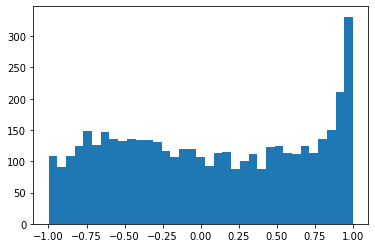

In [18]:
plt.hist(unfam_signal_corrs, bins=35)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  3.,   1.,   2.,   6.,  14.,  21.,  30.,  47.,  73., 117., 160.,
        195., 272., 322., 352., 397., 370., 377., 322., 294., 218., 153.,
        126.,  87.,  52.,  27.,  25.,  14.,  10.,   2.,   4.,   0.,   0.,
          1.,   1.]),
 array([-0.50867668, -0.47651202, -0.44434736, -0.41218269, -0.38001803,
        -0.34785336, -0.3156887 , -0.28352403, -0.25135937, -0.2191947 ,
        -0.18703004, -0.15486537, -0.12270071, -0.09053605, -0.05837138,
        -0.02620672,  0.00595795,  0.03812261,  0.07028728,  0.10245194,
         0.13461661,  0.16678127,  0.19894594,  0.2311106 ,  0.26327526,
         0.29543993,  0.32760459,  0.35976926,  0.39193392,  0.42409859,
         0.45626325,  0.48842792,  0.52059258,  0.55275725,  0.58492191,
         0.61708657]),
 <a list of 35 Patch objects>)

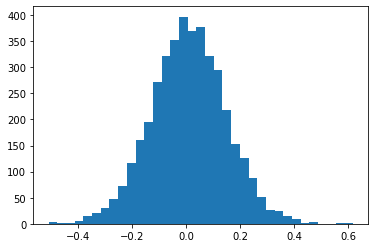

In [19]:
plt.hist(fam_noise_corrs, bins=35)

(array([  2.,   1.,   2.,   7.,   8.,  11.,  34.,  46.,  68., 129., 172.,
        250., 292., 356., 429., 400., 424., 393., 346., 276., 241., 133.,
        108.,  99.,  55.,  44.,  17.,  14.,   5.,   4.,   1.,   1.,   1.,
          1.,   1.]),
 array([-0.51223333, -0.47874972, -0.44526611, -0.41178249, -0.37829888,
        -0.34481527, -0.31133166, -0.27784805, -0.24436444, -0.21088082,
        -0.17739721, -0.1439136 , -0.11042999, -0.07694638, -0.04346276,
        -0.00997915,  0.02350446,  0.05698807,  0.09047168,  0.1239553 ,
         0.15743891,  0.19092252,  0.22440613,  0.25788974,  0.29137336,
         0.32485697,  0.35834058,  0.39182419,  0.4253078 ,  0.45879142,
         0.49227503,  0.52575864,  0.55924225,  0.59272586,  0.62620948,
         0.65969309]),
 <a list of 35 Patch objects>)

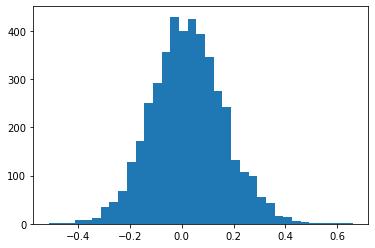

In [20]:
plt.hist(unfam_noise_corrs, bins=35)

In [21]:
np.nanmean(fam_noise_corrs)

0.009700747314013259

In [22]:
np.nanmean(unfam_noise_corrs)

0.02380181577290786

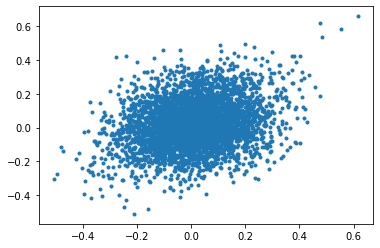

In [23]:
plt.plot(fam_noise_corrs, unfam_noise_corrs, '.')

In [ ]:
test = get_stim_zscores(spikes, trials, good_clusters, 'P_40k', fs)

In [ ]:
test.shape

In [ ]:
stim_subintervals = np.linspace(0, 1, 7)
subint_noisecorrs = []
for (a, b) in tqdm(zip(stim_subintervals[:-1], stim_subintervals[1:])):
    subint_zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs, interval=[a,b])
    subint_noisecorrs.append(get_all_stim_avg_noise_correlation(subint_zscores, good_clusters))

In [ ]:
subint_noisecorrs[0].shape

In [ ]:
nc_v_time = np.array([(i, x) for i, y in enumerate(subint_noisecorrs) for x in y ])
mean_nc_v_time = np.array([(i, np.nanmean(x)) for i, x in enumerate(subint_noisecorrs)])
std_nc_v_time = np.array([(i, np.nanstd(x)) for i, x in enumerate(subint_noisecorrs)])

In [ ]:
plt.plot(nc_v_time[:, 0],  nc_v_time[:, 1], '.')

In [ ]:
plt.plot(mean_nc_v_time[:, 0], mean_nc_v_time[:, 1])